In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
import cvxpy as cp

In [8]:
# Define the tickers for the ETFs
tickers = ['VTI', 'AGG', 'DBC', 'VIX']

# Fetch historical data from Yahoo Finance
data = yf.download(tickers, start="2006-01-01", end="2019-04-30")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Define a lookback window for input features
lookback_window = 50

# Prepare the dataset for LSTM
def create_lstm_dataset(returns, lookback_window):
    X, y = [], []
    for i in range(len(returns) - lookback_window):
        X.append(returns.iloc[i:(i + lookback_window)].values)
        y.append(returns.iloc[i + lookback_window].values)
    return np.array(X), np.array(y)

X, y = create_lstm_dataset(returns, lookback_window)

[*********************100%%**********************]  4 of 4 completed


In [9]:


# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(lookback_window, len(tickers))))
model.add(Dense(len(tickers)))
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [10]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
27/27 [==============================] - 3s 44ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 2/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 3/50
27/27 [==============================] - 1s 55ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 4/50
27/27 [==============================] - 1s 50ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 5/50
27/27 [==============================] - 1s 49ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 6/50
27/27 [==============================] - 2s 84ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 7/50
27/27 [==============================] - 2s 64ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 8/50
27/27 [==============================] - 1s 51ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 9/50
27/27 [==============================] - 1s 25ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 10/50
27/27 [==============================] - 1s 26ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 11/

In [11]:
# Evaluate the model on the test set
test_performance = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_performance}')


7/7 [==============================] - 0s 8ms/step - loss: 0.0625
Test Loss: 0.06249236688017845


In [12]:
# Traditional Method


# Assuming 'returns' is a pandas DataFrame of historical returns
expected_returns = returns.mean().values  # Convert to numpy array
cov_matrix = returns.cov().values  # Convert to numpy array

# Ensure that 'weights' is a column vector with the same number of rows as there are assets
weights = cp.Variable(expected_returns.shape[0])

# Define the optimization problem
risk_free_rate = 0.01  # Example risk-free rate
objective = cp.Maximize(expected_returns.T @ weights - risk_free_rate - cp.quad_form(weights, cov_matrix))
constraints = [cp.sum(weights) == 1, weights >= 0]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve()

# Get the optimal weights
optimal_weights_mpt = weights.value


In [13]:
# Function to calculate Sharpe ratio
def calculate_sharpe_ratio(returns, weights, risk_free_rate=0.0):
    # Calculate expected portfolio return
    expected_portfolio_return = np.sum(returns.mean() * weights) * 252  # Annualize the return

    # Calculate portfolio standard deviation
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualize the std dev

    # Calculate Sharpe ratio
    sharpe_ratio = (expected_portfolio_return - risk_free_rate) / portfolio_std_dev
    return sharpe_ratio

predicted_weights_lstm = model.predict(X_test)
# Calculate Sharpe ratio for LSTM model
# Assuming predicted_weights_lstm contains the predicted weights from the LSTM model
sharpe_ratio_lstm = calculate_sharpe_ratio(returns, predicted_weights_lstm.mean(axis=0))

# Calculate Sharpe ratio for MPT model
# Assuming optimal_weights_mpt contains the optimal weights from the MPT optimization
sharpe_ratio_mpt = calculate_sharpe_ratio(returns, optimal_weights_mpt)

# Compare the Sharpe ratios
print(f'Sharpe Ratio LSTM: {sharpe_ratio_lstm}')
print(f'Sharpe Ratio MPT: {sharpe_ratio_mpt}')


7/7 [==============================] - 0s 8ms/step
Sharpe Ratio LSTM: -0.08031652809018817
Sharpe Ratio MPT: 0.7906346678286695


In [14]:
def simulate_portfolio_performance(weights, initial_investment, returns):
    # Calculate daily portfolio returns
    daily_returns = (weights * returns).sum(axis=1)

    # Calculate cumulative returns
    cumulative_returns = (1 + daily_returns).cumprod()

    # Calculate portfolio value over time
    portfolio_values = initial_investment * cumulative_returns
    return portfolio_values

# Initial investment
initial_investment = 10000

# Simulate LSTM portfolio performance
lstm_portfolio_values = simulate_portfolio_performance(predicted_weights_lstm.mean(axis=0), initial_investment, returns.iloc[train_size:])

# Simulate MPT portfolio performance
mpt_portfolio_values = simulate_portfolio_performance(optimal_weights_mpt, initial_investment, returns.iloc[train_size:])



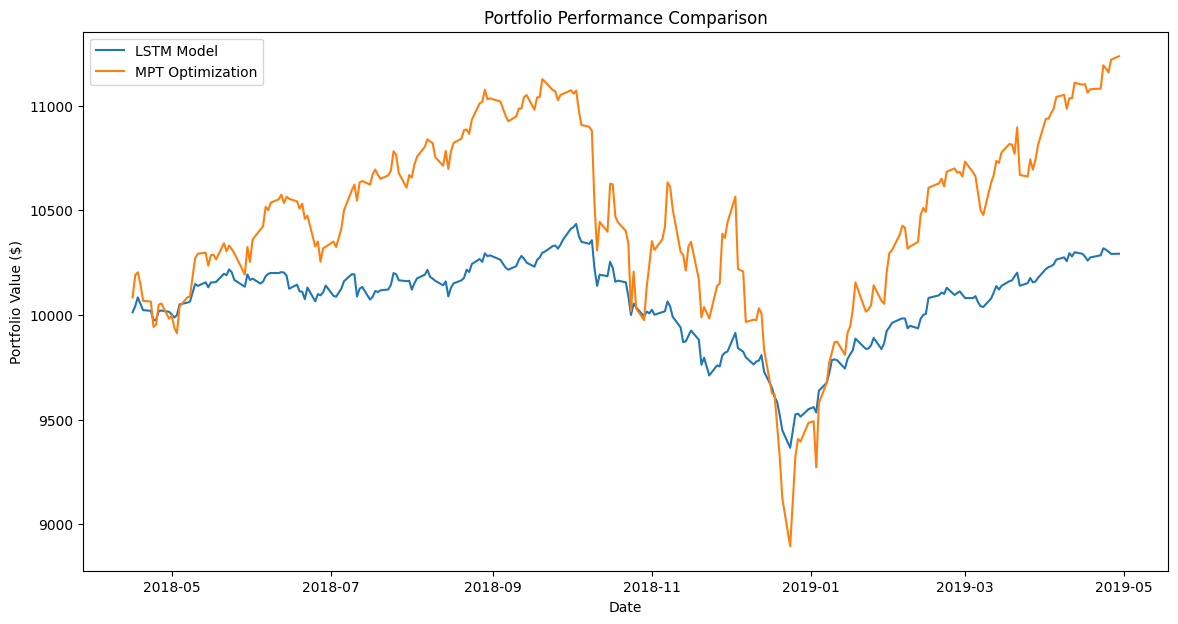

In [15]:
import matplotlib.pyplot as plt

# Plot the portfolio values over time
plt.figure(figsize=(14, 7))
plt.plot(lstm_portfolio_values.index, lstm_portfolio_values, label='LSTM Model')
plt.plot(mpt_portfolio_values.index, mpt_portfolio_values, label='MPT Optimization')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Performance Comparison')
plt.legend()

# Show the plot
plt.show()
